# Faryar Memon
##### ID: 14770bef0541f000 <br>
-----
#### STAGE E: Practical Time Series Analysis & Forecast
----- 
<br>[Dataset](https://github.com/HamoyeHQ/HDSC-Time-series-analysis-and-forecast) Description:

      - FullDate: Date in format yyyy-mm-dd  hh:mm:ss
      - ElecPrice: Prices of electricity charged in Kw per hour
      - Gas Price: power generated was done via a gas power plant, gas price is the price of gas at time-T
      - SysLoad: Total Load on system or Power consumed at time-T 
      - Tmax: maximum temperature at time-T
     
<br>

# Data Preprocessing 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [4]:
path = '/content/Time_series_analysis_and_forecast_DATASET.csv'
df = pd.read_csv(path)
df.head(4)

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910


In [5]:
df["FullDate"] = pd.to_datetime(df["FullDate"])

In [6]:
df = df.set_index("FullDate")

In [7]:
def DB_Info(df):
    """
    Returns detailed information about the dataset such as it's data types, 
    basics statistics, number of missing values in each columns & duplicated rows
    """
    print(df.info())
    print('-'*20)
    print(df.describe(include='all'))
    print('-'*20)
    d = df.isnull().sum()
    # prints the columns with null values with a total count of null values it contains
    if d[d>0].any():
      print(d[d>0])
    else:
      print('There are no null values')
    print('-'*20)
    # prints the duplicated rows
    if df.duplicated().any():
      print(df[df.duplicated()])
    else:
      print('There are no duplicated rows')
    print('-'*20)
    for col in df.columns:
      a = df[col].unique()
      if len(a)<15:
        print(f'{col} has {len(a)} unique values ->> {a}', end = '\n\n')
    
DB_Info(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92016 entries, 2010-09-01 00:00:00 to 2021-02-28 23:00:00
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tmax       92016 non-null  float64
 1   SysLoad    92016 non-null  float64
 2   GasPrice   92016 non-null  float64
 3   ElecPrice  92016 non-null  float64
dtypes: float64(4)
memory usage: 3.5 MB
None
--------------------
               Tmax       SysLoad      GasPrice     ElecPrice
count  92016.000000  92016.000000  92016.000000  92016.000000
mean     231.696688    797.623357      6.016163     65.798356
std     4562.128748    613.520156      2.608116    213.144084
min        9.900000  -1596.810100      0.000000   -924.820000
25%       17.300000    417.119800      3.936900     31.543750
50%       21.900000    856.467925      5.165600     48.715000
75%       27.600000   1221.293675      8.023300     76.495000
max    99999.900000   3264.166300     29.990000  14700.

No null values or duplicated rows are present in this dataset.

# Q 11

Resample the data from an hour sampling rate to a daily sampling rate (i.e sum over the hours for each day). Which of the following is a plot of ElecPrice over time?

In [8]:
daily_df = df.resample('D').sum()
daily_df.reset_index(inplace = True)

Text(0, 0.5, 'Electric Price')

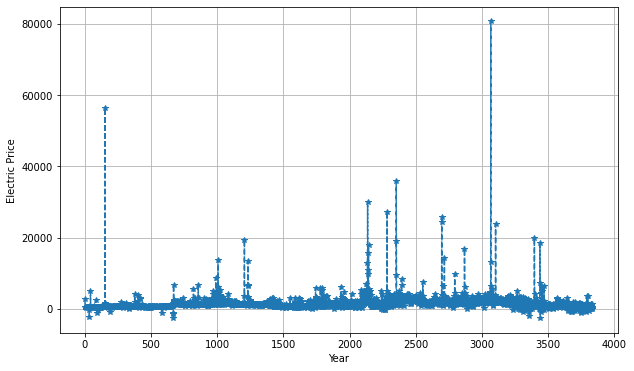

In [23]:
plt.figure(figsize=( 10 , 6 ))
plt.plot(daily_df.index, daily_df['ElecPrice'], '--' , marker= '*')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Electric Price')

# Q12

Using the Augmented Dicky Fuller test (ADF), what is the P-value of the SysLoad and GasPrice of the resampled Data set, to 6 decimal places?


In [24]:
SysLoad_ADF = adfuller(daily_df['SysLoad'])
GasPrice_ADF = adfuller(daily_df['GasPrice'])

In [54]:
print(f'p-value of SysLoad is {round(SysLoad_ADF[1], 6)} & GasPrice is {round(GasPrice_ADF[1], 6)}.')

p-value of SysLoad is 0.004254 & GasPrice is 0.045027.


### Answer
p-value of SysLoad is 0.004254 & GasPrice is 0.045027 in 6 decimal places.

# Q 13


Using the Augmented Dicky Fuller test (ADF) what are the 10% and 5% critical values of GasPrice and ElecPrice of the resampled Data set, to 4 decimal places?

In [31]:
ElecPrice_ADF = adfuller(daily_df['ElecPrice'])

In [57]:
GasPrice_Crit = round(GasPrice_ADF[4]['10%'], 4)
ElecPrice_Crit = round(ElecPrice_ADF[4]['5%'], 4)
print(f'10% Critical Value of GasPrice is {GasPrice_Crit} & 5% Critical Value of ElecPrice is {ElecPrice_Crit}.')

10% Critical Value of GasPrice is -2.5672 & 5% Critical Value of ElecPrice is -2.8623.


###  Answer:
10% Critical Value of GasPrice is -2.5672 & 5% Critical Value of ElecPrice is -2.8623.

# Q 14 - 16

## Instructions
Using the daily sampling rate (sum), divide the data into a train and test set. The first 2757 days is your train set and the last (x-2757) days is your test set. Where x is the length of the dataset. Use Facebook Prophet to train a Univariate time series model using the FullDate column as (‘dt’ or ‘ds’) and ElecPrice as ( ‘y’). Answer question 14 - 16

In [9]:
# daily_df.head(4)

In [10]:
daily_uni_df = daily_df.drop(columns=['Tmax', 'SysLoad', 'GasPrice'])
daily_uni_df = daily_uni_df.rename(columns={"FullDate": "ds", "ElecPrice": "y"})
# daily_uni_df.head(4)

In [11]:
daily_uni_train_df = daily_uni_df[:2757]
daily_uni_test_df = daily_uni_df[2757:]

In [12]:
daily_uni_train_df.shape, daily_uni_test_df.shape

((2757, 2), (1077, 2))

In [13]:
# daily_uni_train_df.head(4)
# daily_uni_test_df.head(4)

In [14]:
uni_model = Prophet()
uni_model.fit(daily_uni_train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
uni_forecast = uni_model.predict(daily_uni_test_df)

In [16]:
# uni_forecast.head(4)

## Q 14
Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places?

Hint:

Define a function that calculates the Mape using the definition of MAPE from the course Module and pass your dataset into it.

In [34]:
def MAPE(y_true, y_pred, round_x): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return round(MAPE, round_x)

In [59]:
uni_MAPE = MAPE(daily_uni_test_df['y'], uni_forecast['yhat'], 2)
print(f' MAPE of the univariate time series is {uni_MAPE}%.')

 MAPE of the univariate time series is 549.48%.


 ### Answer:
 MAPE (%) of the univariate time series is 549.48% in 2 decimal places.

## Q 15
What is the RMSE in 2 decimal places?


In [60]:
# rmse

uni_RMSE = round(np.sqrt(mean_squared_error(daily_uni_test_df['y'], uni_forecast['yhat'])), 2)
print(f'RMSE of the univariate time series is {uni_RMSE}.')

RMSE of the univariate time series is 3218.16.


### Answer:
RMSE of the univariate time series is 3218.16 in 2 decimal places.

## Q 16
If you plot the components from the forecasted model, what month of the yearly seasonality has the highest value?

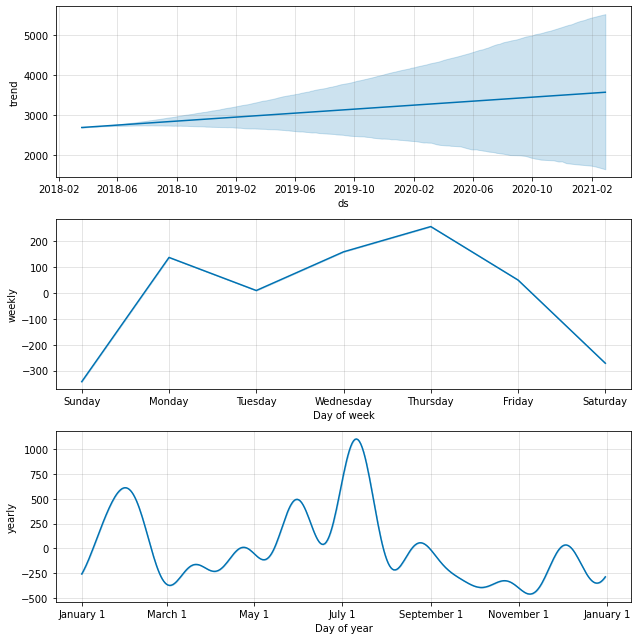

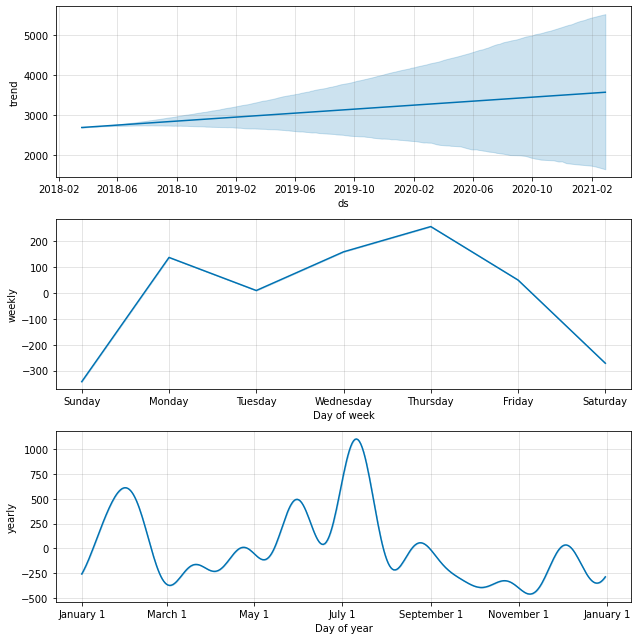

In [39]:
uni_model.plot_components(uni_forecast)

### Answer:

 **July** is the month of the yearly seasonality having the highest value.

# Q 17 - 19

## Instructions:
Multivariate Time Series Forecasting with Facebook Prophet

In the last exercise, we used only the dependent variable (ElecPrice) and the time component for our modeling (ds vs y). Next, we will build a time series model using the other variables. These variables will be added to the forecast model as a regressor on Facebook Prophet. So the 3 independent variables [‘SysLoad’,’Tmax’,’GasPrice’'] will be [‘add1’, ‘add2’, ‘add3’’] as the regressors. Split the data into train and test as done above and build a multivariate forecast model to forecast the last x-2757 days of ElecPrice. Answer question 17-19

In [17]:
daily_mult_df = daily_df.copy()

In [18]:
daily_mult_df = daily_mult_df.rename(columns={'FullDate': 'ds','SysLoad': 'add1', 
                                              'Tmax': 'add2','GasPrice': 'add3','ElecPrice': 'y'})
daily_mult_df.head(3)

,ds,add2,add1,add3,y
0,2010-09-01,379.2,41565.38,88.56,2751.700
1,2010-09-02,369.6,38898.99,88.56,570.810
2,2010-09-03,439.2,41665.76,106.80,504.975


In [19]:
daily_mult_train_df = daily_mult_df[:2757]
daily_mult_test_df = daily_mult_df[2757:]

daily_mult_train_df.shape, daily_mult_test_df.shape

((2757, 5), (1077, 5))

In [20]:
mult_model = Prophet()
mult_model.add_regressor('add1')
mult_model.add_regressor('add2')
mult_model.add_regressor('add3')
mult_model.fit(daily_mult_train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
mult_forecast = mult_model.predict(daily_mult_test_df)

In [22]:
# mult_forecast.head(5)

## Q 17

Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places?

In [61]:
mult_MAPE = MAPE(daily_mult_test_df['y'], mult_forecast['yhat'], 2)
print(f'MAPE of multivariate time series is {mult_MAPE}%.')

MAPE of multivariate time series is 233.74%.


### Answer
MAPE of multivariate time series is 233.74%.

## Q 18

What is the RMSE in 2 decimal places?

In [62]:
# rmse

mult_RMSE = round(np.sqrt(mean_squared_error(daily_mult_test_df['y'], mult_forecast['yhat'])), 2)
print(f'RMSE of the multivariate time series is {mult_RMSE}.')

RMSE of the multivariate time series is 2709.65.


### Answer:
RMSE of the multivariate time series is 2709.65 in 2 decimal places.


## Q 19
If you plot the components from the multivariate forecasted model, what day of the daily seasonality has the highest value?

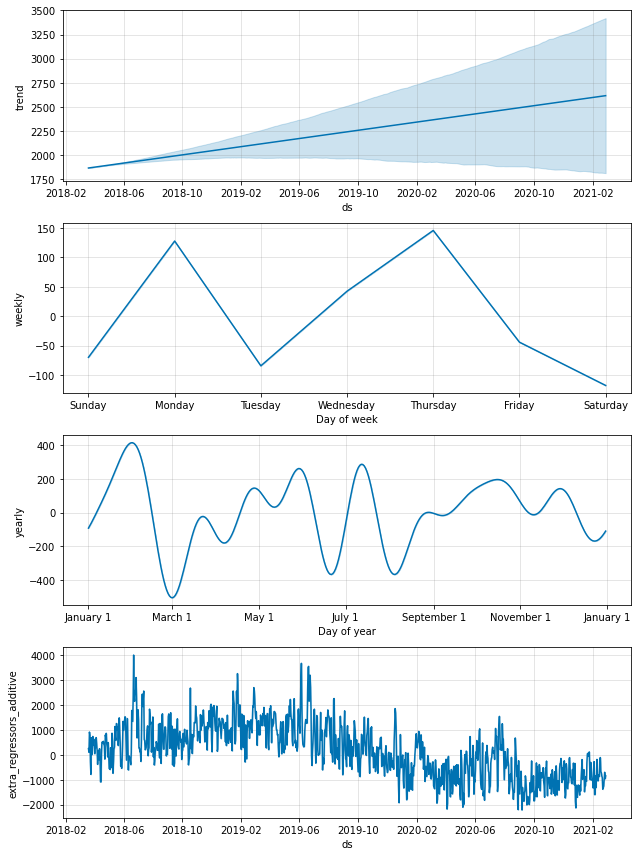

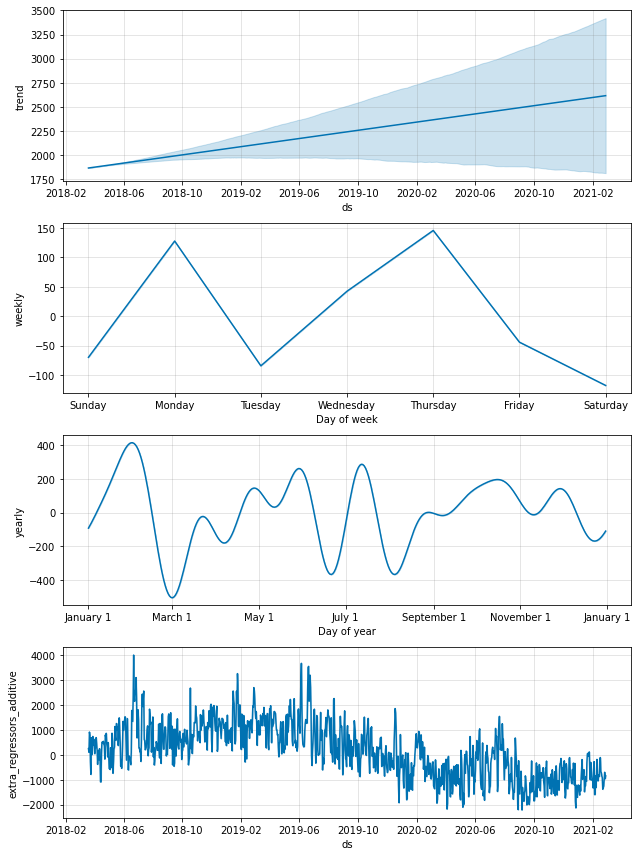

In [42]:
mult_model.plot_components(mult_forecast)

### Answer:

The day with the highest value in the daily seasonality plot is **Thursday.**

# Q 20

Train a multivariate time series model performing the same train test split as before, but now exclude T-max from the training data(drop T-max),

What is the mean absolute percentage error (MAPE) to 2 decimal places on the test set?

In [43]:
mult2_train_df = daily_mult_train_df.drop(columns=['add2'])
mult2_test_df = daily_mult_test_df.drop(columns=['add2'])


In [46]:
mult_model2 = Prophet()
mult_model2.add_regressor('add1')
mult_model2.add_regressor('add3')

In [47]:
mult_model2.fit(mult2_train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [50]:
mult_forecast_2 = mult_model2.predict(mult2_test_df)

In [63]:
mult_MAPE_2 = MAPE(mult2_test_df['y'], mult_forecast_2['yhat'], 2)
print(f'MAPE of the multivariate time series without Tmax is {mult_MAPE_2}%.')

MAPE of the multivariate time series without Tmax is 236.66%.


MAPE of the multivariate time series without Tmax is 236.66% in 2 decimal places.